# 02 Data Preprocessing EDA
Đọc dữ liệu CSV.

Xử lý missing values, định dạng ngày giờ.

Tính toán comfort index và gán nhãn.

Phân tích thăm dò (EDA) với biểu đồ, thống kê mô tả.

# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append(r"D:\weather-tourism-project")

# Hiển thị trực quan tốt hơn
sns.set(style="whitegrid")


# 2. Đọc dữ liệu từ CSV

In [2]:
df1 = pd.read_csv(r"D:\weather-tourism-project\data\weather_combined.csv", sep=",", header=0)
df1.head()

,date,hour,temp,rain_amount,humidity,wind,cloud,precip,city
0,2024-01-01,0,18.4,0.0,92,6.9,3,0.0,HaNoi
1,2024-01-01,1,18.0,0.0,95,6.1,9,0.0,HaNoi
2,2024-01-01,2,17.7,0.0,97,5.3,96,0.0,HaNoi
3,2024-01-01,3,17.8,0.0,97,4.9,100,0.0,HaNoi
4,2024-01-01,4,18.7,0.2,93,7.0,41,0.2,HaNoi


In [3]:
df2 = pd.read_csv(r"D:\weather-tourism-project\data\weather_data_raw.csv", sep=",", header=0)
df2.head()

,date,hour,temp,rain_amount,humidity,wind,cloud,precip,city
0,2025-05-23,0,27.2,0.0,91,10.2,100,0.0,HaNoi
1,2025-05-23,1,27.3,0.0,93,9.7,100,0.0,HaNoi
2,2025-05-23,2,27.1,0.0,93,9.9,100,0.0,HaNoi
3,2025-05-23,3,27.1,0.0,94,9.4,100,0.0,HaNoi
4,2025-05-23,4,27.2,0.0,94,9.4,100,0.0,HaNoi


In [4]:
df = pd.concat([df1, df2], axis=0, ignore_index=True)
df.head()

,date,hour,temp,rain_amount,humidity,wind,cloud,precip,city
0,2024-01-01,0,18.4,0.0,92,6.9,3,0.0,HaNoi
1,2024-01-01,1,18.0,0.0,95,6.1,9,0.0,HaNoi
2,2024-01-01,2,17.7,0.0,97,5.3,96,0.0,HaNoi
3,2024-01-01,3,17.8,0.0,97,4.9,100,0.0,HaNoi
4,2024-01-01,4,18.7,0.2,93,7.0,41,0.2,HaNoi


In [5]:
print(df.columns)

Index(['date', 'hour', 'temp', 'rain_amount', 'humidity', 'wind', 'cloud',
       'precip', 'city'],
      dtype='object')


# 3. Tiền xử lý dữ liệu

In [12]:
# Kiểm tra thiếu dữ liệu
print(df.isnull().sum())

# Loại bỏ hoặc điền giá trị thiếu (tuỳ chọn)
df = df.dropna()  # hoặc df.fillna(method='ffill')

df["date"] = pd.to_datetime(df["date"])
df["hour"] = df["hour"].astype(int)


# Hiển thị dữ liệu đã xử lý
print("Dữ liệu sau xử lý:")
print(df.head())


date             0
hour             0
temp             0
rain_amount      0
humidity         0
wind             0
cloud            0
precip           0
city             0
comfort_index    0
label            0
dtype: int64
Dữ liệu sau xử lý:
        date  hour  temp  rain_amount  humidity  wind  cloud  precip   city  \
0 2024-01-01     0  18.4          0.0        92   6.9      3     0.0  HaNoi   
1 2024-01-01     1  18.0          0.0        95   6.1      9     0.0  HaNoi   
2 2024-01-01     2  17.7          0.0        97   5.3     96     0.0  HaNoi   
3 2024-01-01     3  17.8          0.0        97   4.9    100     0.0  HaNoi   
4 2024-01-01     4  18.7          0.2        93   7.0     41     0.2  HaNoi   

   comfort_index       label  
0           67.0  Trung bình  
1           67.0  Trung bình  
2           58.0  Trung bình  
3           58.0  Trung bình  
4           58.5  Trung bình  


In [9]:
# Lưu dữ liệu đã xử lý
processed_file = r"D:\weather-tourism-project\data\processed_weather_data.csv"
df.to_csv(processed_file, index=False)
print(f"Đã lưu dữ liệu đã xử lý vào {processed_file}")


Đã lưu dữ liệu đã xử lý vào D:\weather-tourism-project\data\processed_weather_data.csv


In [10]:
from scripts.db_connection import get_mongo_collection

collection = get_mongo_collection()

Connection success: weather_tourism.weather_data


In [11]:
collection.delete_many({})
collection.insert_many(df.to_dict("records"))
print(f"Đã lưu {len(df)} bản ghi vào MongoDB")

Đã lưu 36936 bản ghi vào MongoDB


# 4. Tính toán chỉ số Comfort Index

In [7]:
def calculate_comfort_index(row):
    # Nhiệt độ lý tưởng ở Việt Nam là khoảng 26–30°C
    if 26 <= row['temp'] <= 30:
        temp_score = 100
    elif 24 <= row['temp'] < 26 or 30 < row['temp'] <= 32:
        temp_score = 80
    elif 22 <= row['temp'] < 24 or 32 < row['temp'] <= 34:
        temp_score = 60
    else:
        temp_score = 40

    # Độ ẩm lý tưởng là 50–70%
    if 50 <= row['humidity'] <= 70:
        humidity_score = 100
    elif 40 <= row['humidity'] < 50 or 70 < row['humidity'] <= 80:
        humidity_score = 70
    else:
        humidity_score = 40

    # Gió nhẹ là lý tưởng (3–10 km/h)
    if 3 <= row['wind'] <= 10:
        wind_score = 100
    elif 1 <= row['wind'] < 3 or 10 < row['wind'] <= 15:
        wind_score = 70
    else:
        wind_score = 50

    # Mưa dưới 0.5mm là lý tưởng
    if row['rain_amount'] == 0:
        rain_score = 100
    elif row['rain_amount'] < 0.5:
        rain_score = 80
    elif row['rain_amount'] < 2:
        rain_score = 50
    else:
        rain_score = 20

    # Mây dưới 30% là tốt
    if row['cloud'] <= 30:
        cloud_score = 100
    elif row['cloud'] <= 60:
        cloud_score = 70
    else:
        cloud_score = 40

    # Trọng số: nhiệt độ 35%, độ ẩm 20%, gió 10%, mưa 20%, mây 15%
    comfort_index = (
        temp_score * 0.35 +
        humidity_score * 0.2 +
        wind_score * 0.1 +
        rain_score * 0.2 +
        cloud_score * 0.15
    )

    return comfort_index


In [8]:
def assign_label(score):
    if score >= 75:
        return "Tốt"
    elif score >= 50:
        return "Trung bình"
    else:
        return "Xấu"

df['comfort_index'] = df.apply(calculate_comfort_index, axis=1)
df['label'] = df['comfort_index'].apply(assign_label)


# 5. EDA: Thống kê mô tả và biểu đồ

In [41]:
# Tổng quan các chỉ số thời tiết
print(df.describe())


                                date         hour          temp   rain_amount  \
count                          36936  36936.00000  36936.000000  36936.000000   
mean   2024-09-13 00:39:17.894736896     11.50000     25.798565      0.245251   
min              2024-01-01 00:00:00      0.00000      7.200000      0.000000   
25%              2024-05-08 00:00:00      5.75000     23.200000      0.000000   
50%              2024-09-13 00:00:00     11.50000     25.900000      0.000000   
75%              2025-01-19 00:00:00     17.25000     28.900000      0.100000   
max              2025-05-29 00:00:00     23.00000     42.000000     35.900000   
std                              NaN      6.92228      4.868946      1.080538   

           humidity          wind         cloud        precip  comfort_index  
count  36936.000000  36936.000000  36936.000000  36936.000000   36936.000000  
mean      79.043887      7.574548     74.999134      0.249561      72.722899  
min       22.000000      0.000000

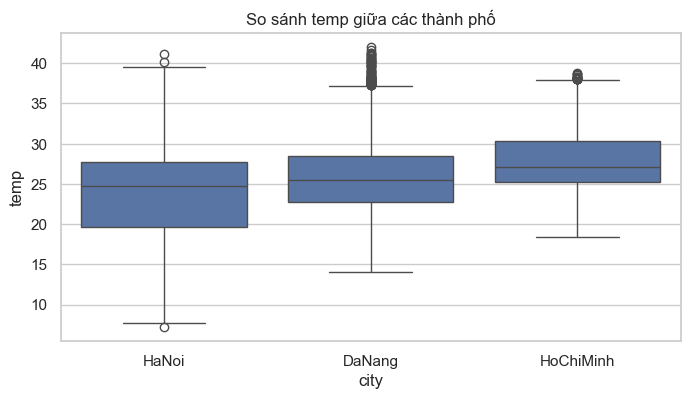

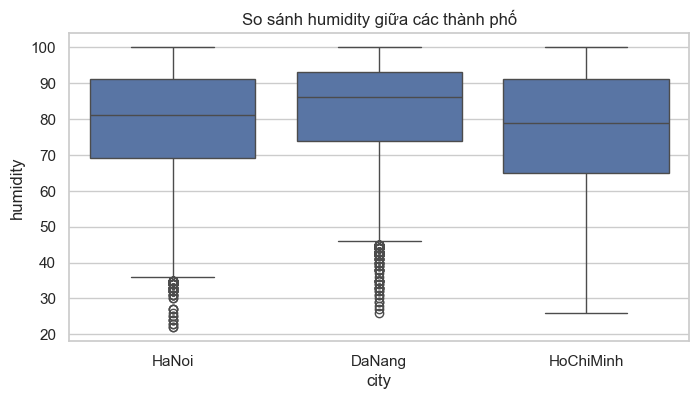

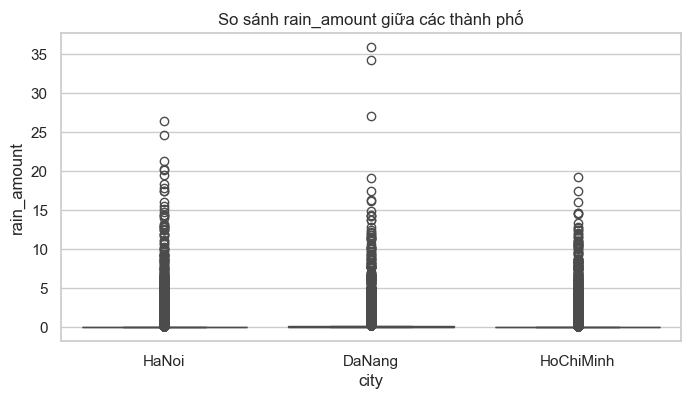

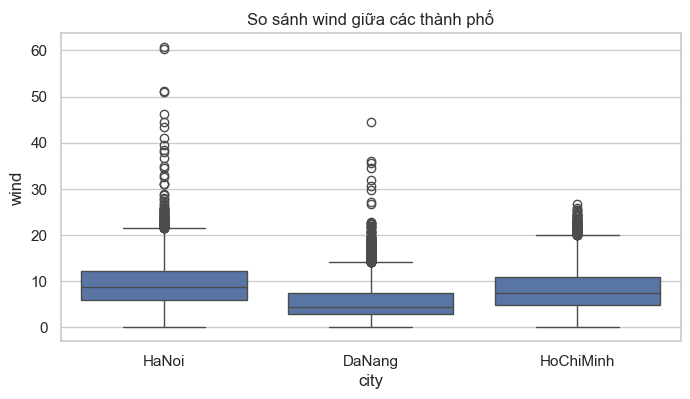

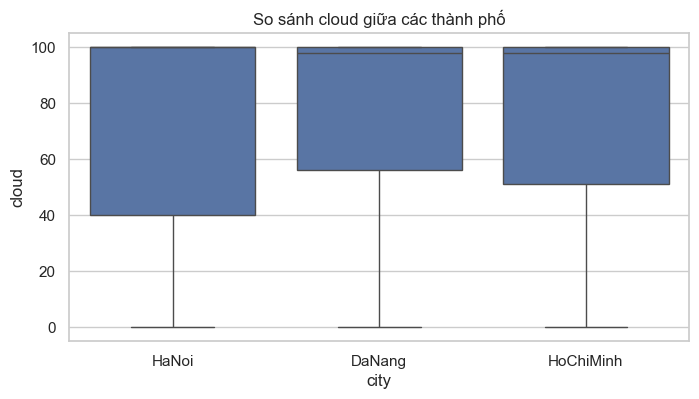

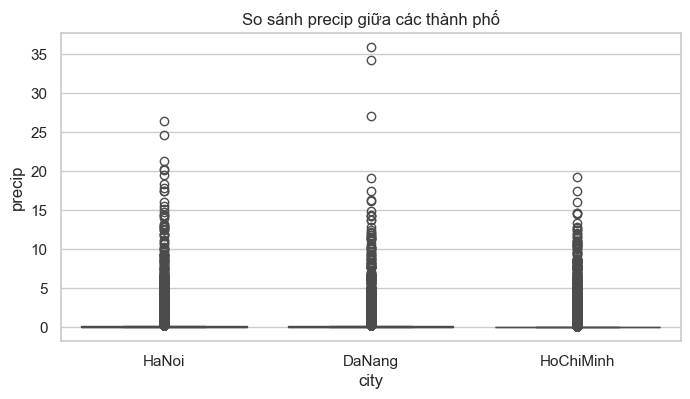

In [43]:
for col in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x="city", y=col)
    plt.title(f"So sánh {col} giữa các thành phố")
    plt.show()


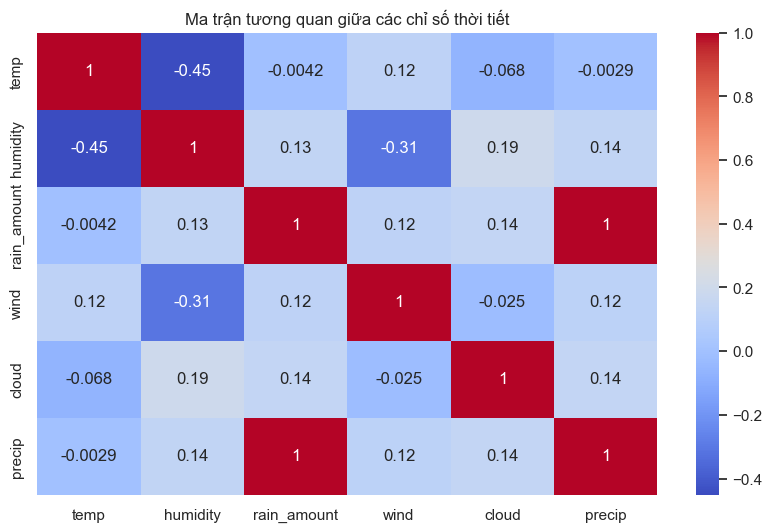

In [44]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm")
plt.title("Ma trận tương quan giữa các chỉ số thời tiết")
plt.show()


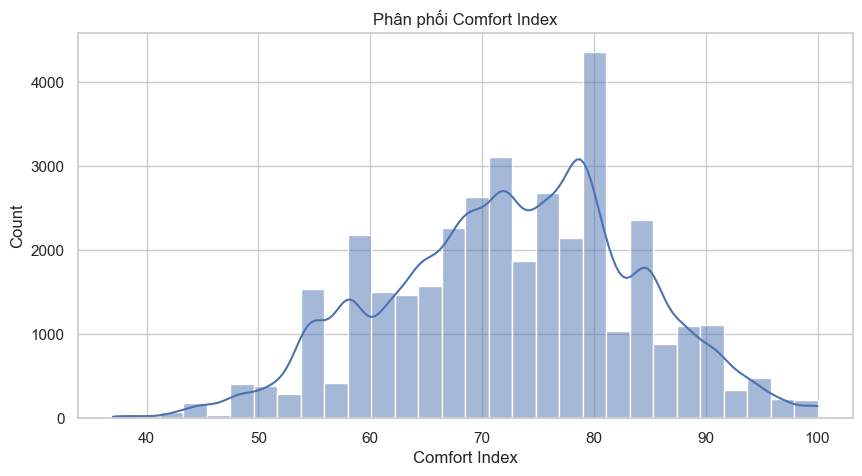

In [34]:
#  EDA - Phân phối comfort index
plt.figure(figsize=(10,5))
sns.histplot(df["comfort_index"], bins=30, kde=True)
plt.title("Phân phối Comfort Index")
plt.xlabel("Comfort Index")
plt.show()

              temp                                                     \
             count       mean       std   min   25%   50%   75%   max   
city                                                                    
DaNang     12312.0  25.834665  4.439968  14.0  22.7  25.5  28.5  42.0   
HaNoi      12312.0  23.732545  5.607076   7.2  19.6  24.7  27.7  41.1   
HoChiMinh  12312.0  27.828484  3.402960  18.4  25.2  27.1  30.3  38.8   

          rain_amount            ...            humidity             \
                count      mean  ...  75%   max    count       mean   
city                             ...                                  
DaNang        12312.0  0.278955  ...  0.1  35.9  12312.0  82.290530   
HaNoi         12312.0  0.250918  ...  0.0  26.4  12312.0  78.492528   
HoChiMinh     12312.0  0.205880  ...  0.0  19.3  12312.0  76.348603   

                                                     
                 std   min   25%   50%   75%    max  
city                      

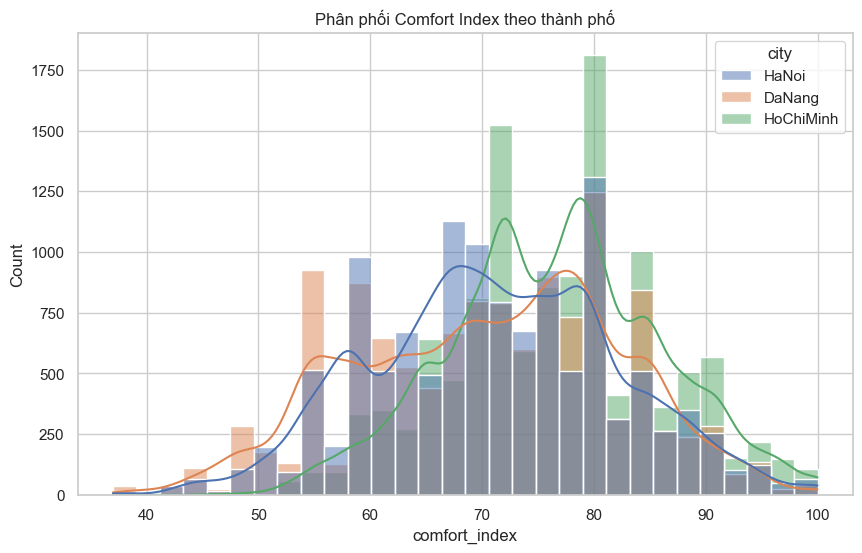

In [35]:
# Thống kê cơ bản theo thành phố
print(df.groupby("city")[['temp', 'rain_amount', 'humidity']].describe())

# Phân phối comfort index
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="comfort_index", hue="city", kde=True, bins=30)
plt.title("Phân phối Comfort Index theo thành phố")
plt.show()

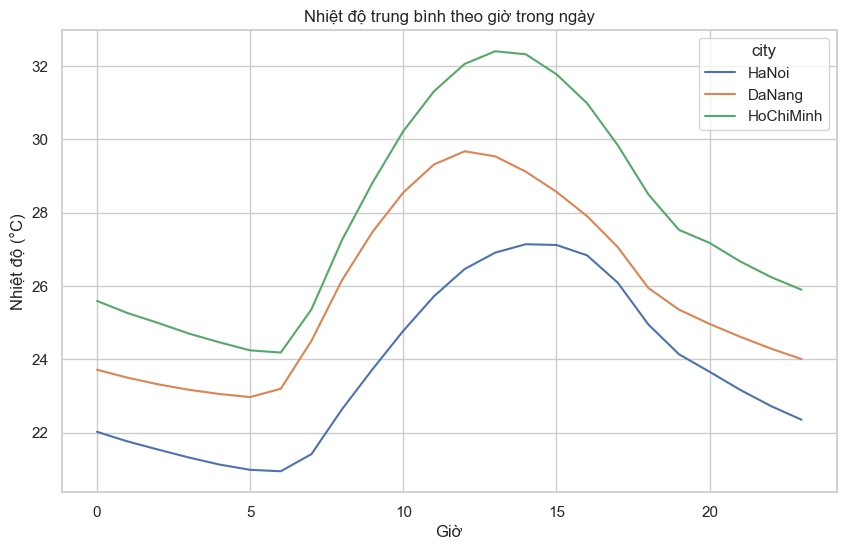

In [37]:
# Biểu đồ nhiệt độ trung bình theo giờ trong ngày
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="hour", y="temp", hue="city", errorbar=None)
plt.title("Nhiệt độ trung bình theo giờ trong ngày")
plt.xlabel("Giờ")
plt.ylabel("Nhiệt độ (°C)")
plt.show()


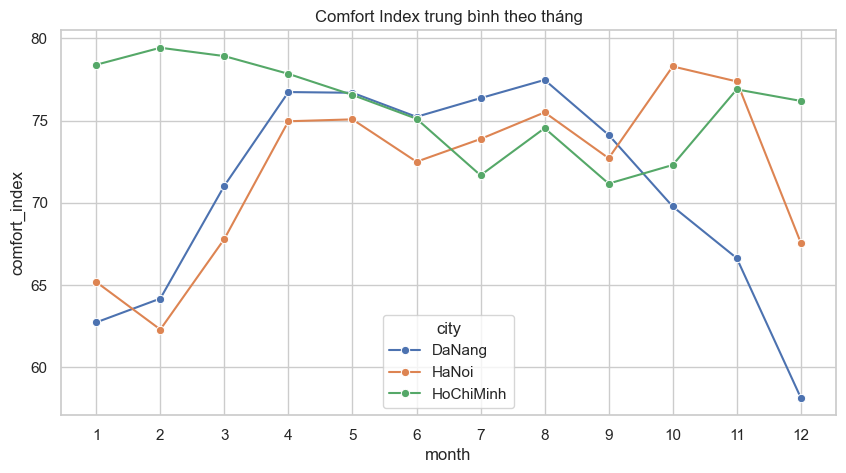

In [47]:
df['month'] = pd.to_datetime(df['date']).dt.month

monthly_avg = df.groupby(['city', 'month'])['comfort_index'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg, x="month", y="comfort_index", hue="city", marker="o")
plt.title("Comfort Index trung bình theo tháng")
plt.xticks(range(1,13))
plt.show()
